# Evaluating a Hypothetical Portfolio

Chao Cheng | May 2019

You have a equally-weighted portfolio that contains the following assets: AAPL, GS, PFE, CVX, and DIS. Use historical data from 2016.1.1 to 2018.1.1 as an in-sample dataset to estimate the expected return and volatility of each single asset, and their correlations. Then use your estimates as inputs to simulate possible future price movements of each stock for the next 6 months, and evaluate the possible loss faced by the portfolio holder at the end of the 6 months.

Note that the possible price movement of each stock should NOT be independent.

## 1. Gathering Historical Data

In [1]:
%load_ext dotenv
%dotenv
import os
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stocks = ["CVX", "DIS", "GS", "PFE", "TXN"]

quandl.ApiConfig.api_key = os.environ.get("API_TOKEN")
stock_data = quandl.get_table(
    "WIKI/PRICES",
    ticker=stocks,
    qopts={"columns": ["date", "ticker", "adj_close"]},
    date={"gte": "2016-1-1", "lte": "2018-1-1"}
)

daily_closes = stock_data.set_index("date").pivot(columns="ticker", values="adj_close")
daily_returns = daily_closes.pct_change()[1:]
annual_returns = daily_returns.mean() * 240
variances = daily_returns.var() * 240
covariance_matrix = daily_returns.cov() * 240

## 2. Simulate Future Price Movements

In [3]:
simulations = []
for i in range(100):
    simulated_prices = {}
    epsilons_matrix = pd.DataFrame(
        data=np.random.multivariate_normal(
            mean=np.zeros(len(stocks)),
            cov=covariance_matrix,
            size=6*20
        ),
        columns=stocks
    )
    for stock in stocks:
        v = annual_returns[stock]
        sigma = np.sqrt(variances[stock])
        t = 1 / 250
        epsilons = epsilons_matrix[stock]

        current_price = daily_closes.iloc[-1][stock]
        prices = [current_price]

        for epsilon in epsilons:
            new_price = np.exp(v * t + sigma * epsilon * np.sqrt(t)) * current_price
            prices.append(new_price)
            current_price = new_price

        simulated_prices[stock] = prices

    simulations.append(pd.DataFrame(simulated_prices))

Price movements for one of the simulations:

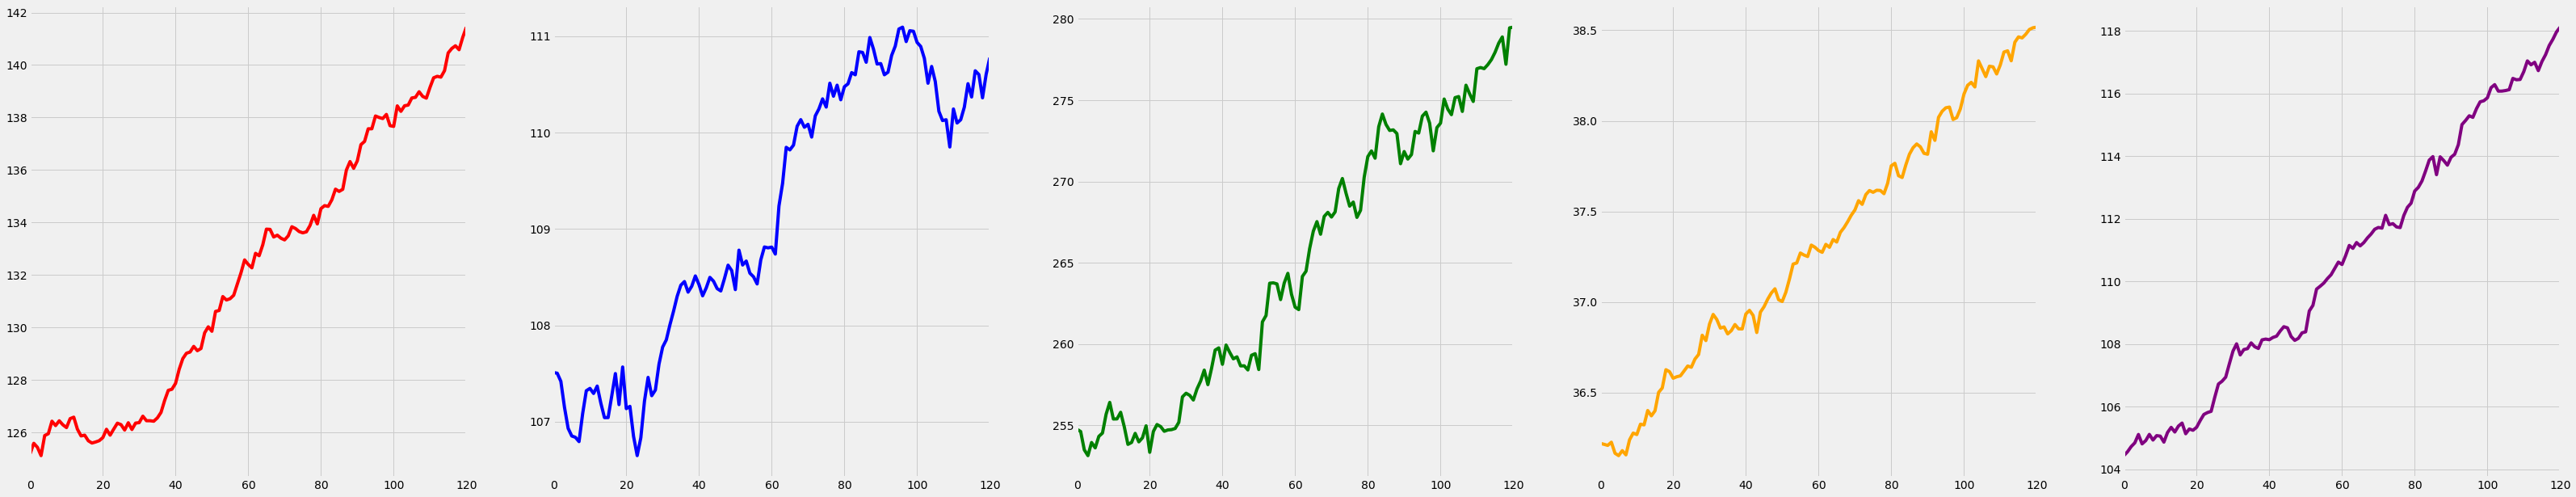

In [4]:
sim = simulations[0]

plt.style.use("fivethirtyeight")
colors = ["red", "blue", "green", "orange", "purple"]
f = plt.figure(figsize=(50, 10))
for i, col in enumerate(sim.columns):
    f.add_subplot(1, 5, i + 1)
    sim[col].plot(color=colors[i], legend=False)

## 3. Evaluate Portfolio Performance

In [5]:
portfolios_dict = {}

for i, simulation in enumerate(simulations):
    initial_portfolio_value = 10000
    initial_allocation_per_stock = initial_portfolio_value / len(stocks)
    
    simulated_returns = simulation.pct_change().fillna(0) + 1
    portfolio_assets = simulated_returns.cumprod() * 2000
    portfolio = portfolio_assets.sum(axis=1)
    portfolios_dict[f"Sim {i}"] = portfolio

portfolios = pd.DataFrame(portfolios_dict)

In [6]:
portfolios.head()

,Sim 0,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,...,Sim 90,Sim 91,Sim 92,Sim 93,Sim 94,Sim 95,Sim 96,Sim 97,Sim 98,Sim 99
0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
1,10007.125633,10010.888392,9993.091640,10034.501501,9995.706364,10010.619682,10040.205354,10006.809959,9980.428706,9988.841190,...,9985.818210,10005.650403,9998.621871,9993.108452,10009.542015,9994.178464,9975.640843,9993.400796,10009.137862,9995.650791
2,9997.105415,10015.379720,10025.683061,10054.387446,10009.886904,10028.484227,10036.335446,10002.401431,9999.893890,9974.203238,...,9989.446555,10008.264253,10013.023230,9997.076196,10002.715564,10021.779219,9986.256183,10018.408905,10000.264347,10023.780877
3,9987.490339,10023.518323,10052.238764,10061.024650,10006.467404,10035.413881,10025.015486,10012.624719,10015.118746,9968.339421,...,10003.604807,10011.240622,10015.539035,9980.690640,10008.436899,10016.201927,10002.376962,10036.330103,9999.937414,10016.583975
4,10003.741423,10009.022726,10050.893327,10056.940981,9997.817048,10044.073303,10041.790721,10002.705447,10006.001046,9944.510075,...,9998.196792,10031.775563,10028.646344,9993.963959,10006.545602,10043.007568,10023.384953,10054.613060,9984.428800,10018.550490


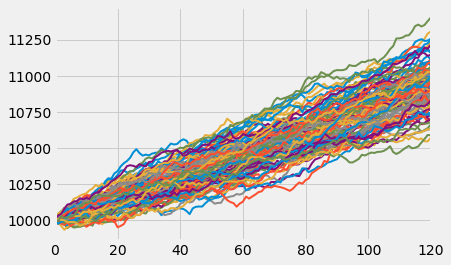

In [7]:
portfolios.plot(linewidth=2, legend=False)